In [1]:
import psycopg2

import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import Voltus_Project_Nathan_Functions_Q3 as functions_q3
import Voltus_Project_Nathan_Functions_Q1_2_Viz as functions_q12v

# Initial Data Processing and EDA
This is just some of my initial data processing and EDA work. I identified some sites that didn't appear to have appropriate data for further analysis (e.g. just one data point, all 0's, etc.) and removed them from a site list that I generate in this section for iterating through the sites later on. I also used subsets of the site list during development to try to test code without having to process the entire data set. Other EDA performed during my work is not included although there may be some parameters generated within my code that are no longer necessary and would have been removed if I had more time to clean things up and refactor my code.

In [3]:
# connecting to the server
conn = psycopg2.connect(
    database="interval_load_data",
    user='postgres',
    password='Onei9yepahShac0renga',
    host="test-interval-load-data.cwr8xr5dhgm1.us-west-2.rds.amazonaws.com",
    port="5432"
)

In [4]:
# querying the sites and their time period
site_df = pd.read_sql_query("SELECT site_id, \
                             MIN(interval_end) as time_start, \
                             MAX(interval_end) as time_end, \
                             (MAX(interval_end) - MIN(interval_end)) as series_length, \
                             COUNT(*) as interval_counts, \
                             AVG(interval_width) as mean_interval_width \
                             FROM intervals \
                             GROUP BY site_id;", conn)

In [5]:
# checking for nulls, only found for kWh
null_df = pd.read_sql_query('SELECT COUNT(*) as kWh_nulls \
                             FROM intervals \
                             WHERE "kWh" IS NULL;', conn)
null_df

,kwh_nulls
0,23


In [6]:
# vast majority of data has intervals of 15-minutes or 1-hour
# the 4 other will need to be looked at in more depth
site_df['mean_interval_width'].value_counts()

900.000000     270
3600.000000     93
996.322396       3
949.035874       1
Name: mean_interval_width, dtype: int64

In [7]:
# general inspection
site_df

,site_id,time_start,time_end,series_length,interval_counts,mean_interval_width
0,35f1db19-ab26-7f30-3451-971f053712f6,2015-05-15 05:00:00,2018-10-04 04:00:00,1237 days 23:00:00,118845,900.0
1,a05598bc-59ac-6697-0673-0e87e7ccc677,2018-06-01 05:15:00,2018-10-07 05:00:00,127 days 23:45:00,12288,900.0
2,b8ec0850-c5ce-1579-5438-8d1247f0ff16,2016-09-05 05:00:00,2018-09-07 04:00:00,731 days 23:00:00,17568,3600.0
3,b9ad1c9b-fbe2-f36f-ab2a-6894c251433f,2018-08-17 07:15:00,2018-09-01 07:00:00,14 days 23:45:00,1056,900.0
4,61ff3699-aad4-35d3-4ecb-b8195e8b08cd,2015-01-01 05:00:00,2018-10-22 04:00:00,1389 days 23:00:00,133434,900.0
...,...,...,...,...,...,...
362,debc4593-d7e7-c1ae-f268-f6944c531e3f,2015-05-15 05:00:00,2018-10-12 04:00:00,1245 days 23:00:00,119452,900.0
363,8a2629e5-183b-05c3-7544-5ac89ee3c347,2018-05-04 05:00:00,2018-10-12 04:00:00,160 days 23:00:00,15453,900.0
364,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2017-06-21 04:15:00,2018-10-12 04:00:00,477 days 23:45:00,45888,900.0
365,a85566bd-7cea-eb51-6aa5-912ee6bdd7d7,2015-05-15 05:00:00,2018-10-12 04:00:00,1245 days 23:00:00,119505,900.0


In [8]:
# the smaller time series will need to be accommodated
np.sort(site_df['interval_counts'].unique())

array([     1,     24,   1056,   1536,   1629,   3048,   3672,   4893,
         5952,   7488,   7630,   8086,   8160,   8424,   8757,   8758,
         8926,   8998,   9094,   9430,   9478,   9622,   9646,  10078,
        10174,  10294,  10678,  10750,  10774,  10798,  10822,  10918,
        10966,  10990,  11014,  11277,  12288,  13623,  14304,  15069,
        15453,  15584,  17194,  17376,  17540,  17568,  18286,  18393,
        18456,  18840,  18946,  18948,  18954,  18960,  19030,  19032,
        19423,  19526,  21116,  21743,  21829,  22516,  23663,  24300,
        30471,  33021,  35592,  36328,  38012,  45888,  60468,  62393,
        65800,  71360,  74112,  74905,  82491,  82647,  82677,  82679,
        82686,  82692,  82695,  82703,  82704,  82711,  82712,  82714,
        82740,  82743,  82747,  82842,  89899,  95066,  95901,  97396,
        97437, 115860, 117551, 118743, 118845, 119319, 119415, 119416,
       119447, 119449, 119452, 119453, 119454, 119455, 119457, 119461,
      

In [9]:
# checking for nulls and confirming datatypes
site_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   site_id              367 non-null    object         
 1   time_start           367 non-null    datetime64[ns] 
 2   time_end             367 non-null    datetime64[ns] 
 3   series_length        367 non-null    timedelta64[ns]
 4   interval_counts      367 non-null    int64          
 5   mean_interval_width  367 non-null    float64        
dtypes: datetime64[ns](2), float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 17.3+ KB


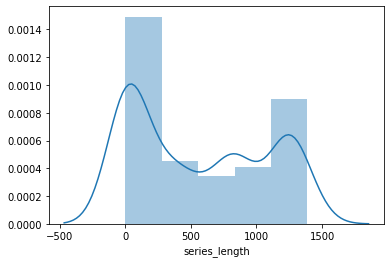

In [10]:
# inspecting the distribution in time series length in days
sns.distplot(site_df['series_length'].dt.days)

In [11]:
# checking for any really small time series and it looks like one might not have enough data to evaluate
# some only have a day of data, but at least you can check that day for start/stop, DR and gaps
site_df['series_length'].sort_values().head()

78    00:00:00
317   23:00:00
213   23:00:00
25    23:00:00
140   23:00:00
Name: series_length, dtype: timedelta64[ns]

In [12]:
# this site had only a single interval of data and was excluded from further analysis
insufficient_data_sites = pd.read_sql_query("SELECT site_id, COUNT(*) FROM intervals \
                                             GROUP BY site_id \
                                             HAVING COUNT(*) < 24;", conn)
insufficient_data_sites

,site_id,count
0,44236c0b-b566-0af2-6675-6854fa9378dd,1


In [13]:
# These sites had either all 0's
# or if some non-0 values existed then they were very small
# and only had a few unique values that didn't look like a load profile.
# These sites were excluded from further analysis as they appear to have corrupted/unusable data
corrupt_sites = pd.read_sql_query("""SELECT site_id, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY "kWh") \
                                     FROM intervals \
                                     GROUP BY site_id \
                                     HAVING PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY "kWh") < 0.05;""", conn)
corrupt_sites

,site_id,percentile_cont
0,0101ee7c-a0ef-7b94-f62b-594142c8b0e6,0.000
1,07ae0994-02e6-2b53-051f-609e8d9efa1e,0.000
2,3bb491cc-4378-1845-cd31-41b0a3c10ad3,0.000
3,7e03e2ca-18ed-5eb8-15d9-d56ad7d89634,0.000
4,9fe91411-9092-2ce4-aabc-dd3c6868d50a,0.032


In [14]:
excluded_sites = pd.concat([insufficient_data_sites['site_id'], corrupt_sites['site_id']])
excluded_sites = list(excluded_sites)
site_df = site_df.loc[site_df['site_id'].isin(list(excluded_sites)) == False]
site_df.reset_index(drop=True, inplace=True)
site_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   site_id              361 non-null    object         
 1   time_start           361 non-null    datetime64[ns] 
 2   time_end             361 non-null    datetime64[ns] 
 3   series_length        361 non-null    timedelta64[ns]
 4   interval_counts      361 non-null    int64          
 5   mean_interval_width  361 non-null    float64        
dtypes: datetime64[ns](2), float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 17.0+ KB


In [15]:
# I want to look closer at the sites with unexpected interval lengths
odd_intervals = list(site_df.loc[(site_df['mean_interval_width'] != 900)
                                 & (site_df['mean_interval_width'] != 3600)]['site_id'])

# There is a pattern here where these four sites have 1296 1-hour intervals covering the same period of time.
# Any future algorithms will need to be able to account for this.
for odd_site in odd_intervals:
    interval_check = pd.read_sql_query(f"SELECT * \
                                        FROM intervals \
                                        WHERE site_id='{odd_site}';", conn)
    hour_time_start = interval_check.loc[interval_check['interval_width'] == 3600]['interval_end'].min()
    hour_time_end = interval_check.loc[interval_check['interval_width'] == 3600]['interval_end'].max()
    print(odd_site)
    print(interval_check['interval_width'].value_counts())
    print('Hourly data starts at ',hour_time_start)
    print('Hourly data ends at ',hour_time_end)
    
# I noticed relatively late (Saturday afternoon) that the data doesn't appear to line up after interval lengths changed
# For the first site listed below, it appears that the post interval transition times series is 5 hours ahead of 
# the pre-transition times, which is suspiciuosly how far ahead GMT is from EST.
# But this was not consistently seen among the other sites,
# so it wasn't entirely clear that all of them had similarly calibrated meters before and after
# as the relative magnitude over time of avg_kW didn't seem the same.
# I decided not to address the issue further in the interest of time.
# Since most of the data is from before the transition, I dropped the data after the transition when
# calculating the daily start/stop and dr events.

e7d819a2-4382-e7d1-a267-069c96a54333
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
871f9fba-e8c7-cdcd-1ac4-863509f1be51
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
66e9c85d-6b5f-d012-4b56-f69218073f86
900     70064
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
cb846659-8aa0-3233-6b11-6745474c94c3
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00


In [16]:
# creating a list of sites to be analyzed for use in loops
site_list = list(site_df['site_id'])
len(site_list)

361

# Analyzing Daily Start/Stop and Potential DR Events
I ended up using a lot of the information generated while determining daily start/stops to try and identify potential DR events, so I looped through the data once and generated the results to both questions. This took a fair amount of time to execute on my computer with the vast majority of the time spent on the Potential DR Events portion due to my approach requiring the calculation of rolling sums of whether I deem the site to be operating during high load periods or not.  
  
My approach to determining whether a site was continuous and its daily start and stop times involved grouping all of a site's data by day of week and interval end, and then taking the median value to generate a model of a typical week's time series. Whether a given day of week was an operating day or not depended on whether or not it's daily near peak load (95th percentile of load vs. 5th percentile for near base load) was closer to the week's maximum daily near peak load or its minimum daily near base load. A 2 sample T-test was then performed on the near peak and base loads for the operating days to determine if they appeared to be from the same population (i.e. continuous) or not. Upon further inspection, there was more variability in how a continuous site's load profile could look and some ambiguity around whether certain sites were daily or continuous based on seemingly mild daily rhythms and/or high variability over time. A more sophisticated approach would be taken given more time and additional data on a given site. Perhaps an unsupervised clustering based approach and/or the inclusion of smoothing (e.g. rolling average or exponential smoothing) to reduce some of the variability that also impacted some start/stop determinations.  
  
My approach to daily start/stop in part followed a method from a document generated by the Lawrence Berkeley National Laboratory titled Electric Load Shape Benchmarking for small-and Medium-Sized Commercial Buildings. In general, the approach is to set an on-hour threshold and then set the time when on-hours begin to the start time and when they end to the stop time. The threshold is defined as the 5th_percentile_of_load + 0.25 * (95th_percentile_of_load - 5th_percentile_of_load). The hourly means from operating days in the modeled typical week were used to generate a model of a typical day for the purposes of evaluating this daily start/stop method. It appeared to work quite well for most buildings, but a one-size fits all approach doesn't appear to be sufficient for all cases, especially when the load curves showed lots of variability, which was at times compounded by having only a handful of days of data.  
  
My approach to identifying potential DR events involved using the modeled typical week to determine the range of high load hours (i.e. hours with load closer to the daily near peak load than the daily near base load) for each day of week to allow for variation throughout the week as not all sites were observed to have a single operating and non-operating load profile. I then looped through each date's high load period and generated a rolling sum of hours that were above the on-hour threshold. For the purposes of this exercise, I assumed a DR event had to last at least 2 continuous hours and the same day must exhibit 5 continuous hours of on-operation to ensure the entire day wasn't an outlier of some sort. Any day that met those criteria was listed as a day with a potential DR event. This approach didn't appear to yield spectacular results with lots of false positives.  
  
With more time I would focus specifically on improving my approach to classifying continuous operation and potential DR events.

In [20]:
# downloading all the data
all_data_df = pd.read_sql_query("""SELECT "kWh"*(3600./interval_width) as "avg_kW",
                                           interval_end, interval_width, site_id \
                                    FROM intervals \
                                    ORDER BY site_id, interval_end asc;"""
                                , conn)
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16648412 entries, 0 to 16648411
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   avg_kW          float64       
 1   interval_end    datetime64[ns]
 2   interval_width  int64         
 3   site_id         object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 508.1+ MB


In [21]:
# generating the deliverables for questions 1 and 2
start_stop_data, dr_event_data = functions_q12v.site_operating_and_dr_status(all_data_df, site_list)

In [22]:
# saving as .csv
start_stop_data.to_csv('deliverables\continuous_flag_and_start_stop_times.csv', index=True)
dr_event_data.to_csv('deliverables\potential_dr_event_days.csv', index=True)

# Identifying Data Gaps
I actually answered this question first because 1) the nature and frequency of the gaps may impact the approach used to solve other problems, which it did to a certain extent by exposing some sites with odd characteristics (i.e. non-constant interval width) and 2) I had the clearest initial idea for answering it. I query the data within the function listed below, but did not do so within the function used to solve the other questions. I had initially intended each question to be answerable independently without previously querying the data mostly in the interest of time and because that function already took so long to process that I didn't include the query during development and testing.  
  
My approach to identifying data gaps was to resample each site's time series so that any gaps would get filled with nulls. I set the index to the interval_end and stored the values where nulls are present. I then shifted the time series ahead and back on interval to align each null with the previous and subsequent interval_end, which could potentially be the start or stop of a gap, and then only retained the previous or subsequent interval_end if that interval_end wasn't in the stored interval_end values with nulls from the original time series. In this way only non-null interval_ends that are adjacent to a null were retained and then they were sorted to generate pairs of values representing the beginning and end of a gap. If a gap was greater than 1-hour then all dates within the gap were retained and delivered in .csv form along with their associated site id.

In [23]:
all_gap_dates = functions_q3.multi_site_gap_date_df(site_list)

In [24]:
# saving to csv
all_gap_dates.to_csv('deliverables\gap_dates.csv', index=False)

# Visualizations
Below are some visualizations showing where my code did and did not work well.

In [25]:
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

## Successful Daily Start/Stop
The following sites appear to have had their start and stop time appropriately identified. Their aggregated weekly load profiles (i.e. median of every hour after shifting the time such that the first interval_end to 00:00:00 of the first day, so note the listed starts/stops are using the transformed time) are plotted in blue with the start times in cyan and stop times in magenta.
  
Site ID **35f1db19-ab26-7f30-3451-971f053712f6**: Overall a good profile and start/stop detection. The lack of a dramatic drop from weekday peak load to weekend peak load led my functions to incorrectly categorize all 7 days as operating days.
  
Site ID **c388dd30-eaeb-dcfe-f76e-e2e6ebf83ce1**: Well processed on all accounts.
  
Site ID **327d1cc1-bf53-33f9-7374-184b3c7838ad**: Well processed on all accounts even with the intermediate daily peaks.
  
Site ID **38ad629b-c319-1371-b46c-ccbbda6b22d9**: This appears to be well processed, but the narrow range of load values could lead one to interpret it as continuous with some daily rhythm.
  
Site ID **8dd2fc1b-0874-7462-b589-7ad334248d13**: Well processed despite having only a single day of data.

<Figure size 1080x288 with 0 Axes>

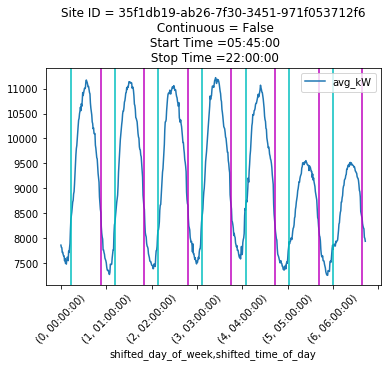

<Figure size 1080x288 with 0 Axes>

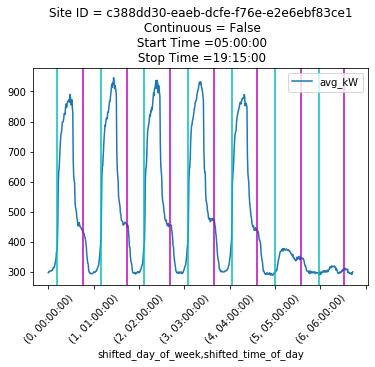

<Figure size 1080x288 with 0 Axes>

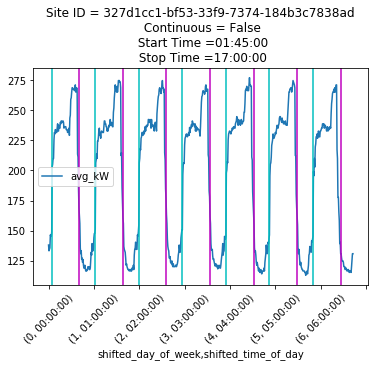

<Figure size 1080x288 with 0 Axes>

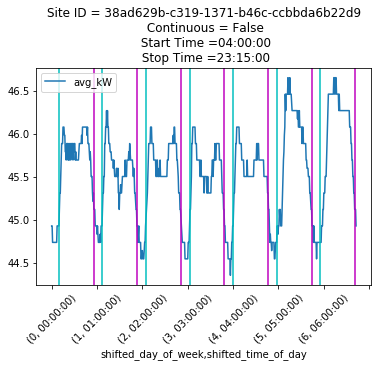

<Figure size 1080x288 with 0 Axes>

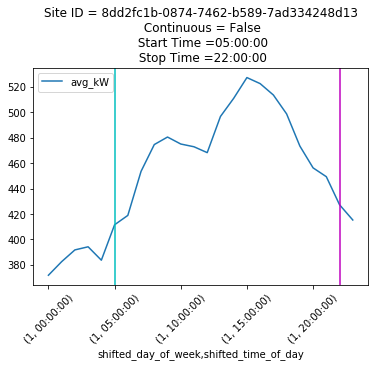

In [27]:
good_daily = ['35f1db19-ab26-7f30-3451-971f053712f6',
              'c388dd30-eaeb-dcfe-f76e-e2e6ebf83ce1',
              '327d1cc1-bf53-33f9-7374-184b3c7838ad',
              '38ad629b-c319-1371-b46c-ccbbda6b22d9',
              '8dd2fc1b-0874-7462-b589-7ad334248d13']
# plotting load profiles in blue, start time in cyan, and stop time in magenta.
functions_q12v.plot_site_operating_status(all_data_df, good_daily)

## Continuous and Potentially Continuous Daily Start/Stop
The following sites appear to be continuously operating for at least part of the week. Their aggregated weekly load profiles (i.e. median of every hour after shifting the time such that the first interval_end to 00:00:00 of the first day, so note the listed starts/stops are using the transformed time) are plotted in blue with the start times in cyan and stop times in magenta.
  
Site ID **e7ef7c8f-7d80-c0ca-03fe-9c0f220c3d7f**: Properly identified as continuous with not daily start or stop.
  
Site ID **6ba0dc29-c307-1388-1637-85349f4e0309**: Characterized as continuous, which it appears to be on the weekends, but the weekdays show a clear rhythm, so it falls somewhat in the middle, though I would have preferred my code identify it as daily. The lack of dramatic peaks and troughs during the week and the much high and very similar peaks and troughs in the weekends fooled my attempt to utilize a T-test.
  
Site ID **fbba4fe0-ad9b-ec46-575c-c22ff0a20186**: Incorrectly identified what appears to be a continuous process because of the short-lived, but not entirely uncommon down spikes that made my code think the site had a dramatically lower base load on some days.
  
Site ID **39b6927a-be1b-dace-b129-5c7dc7fccb9b**: This site appears to have been mis-identified as a daily process due to its intra-week variation, which I hadn't initially expected when constructing my methods for identifying continuous sites.

<Figure size 1080x288 with 0 Axes>

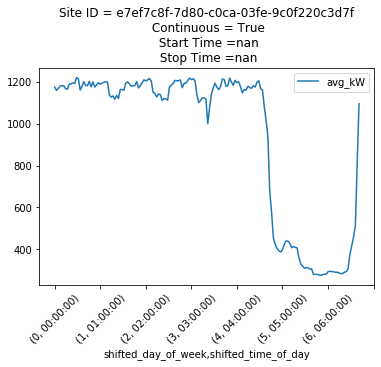

<Figure size 1080x288 with 0 Axes>

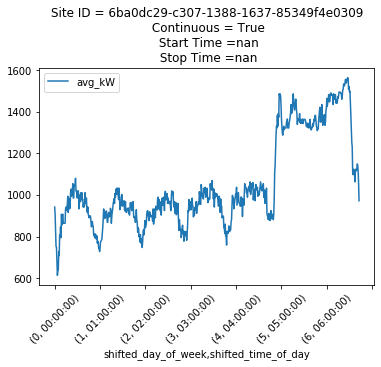

<Figure size 1080x288 with 0 Axes>

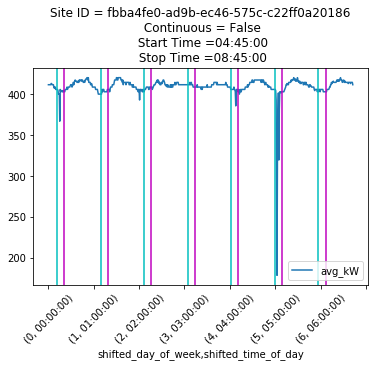

<Figure size 1080x288 with 0 Axes>

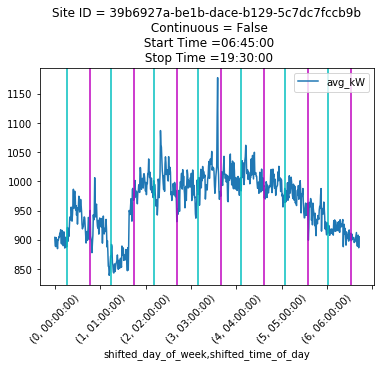

In [28]:
continuousy = ['e7ef7c8f-7d80-c0ca-03fe-9c0f220c3d7f',
               '6ba0dc29-c307-1388-1637-85349f4e0309',
               'fbba4fe0-ad9b-ec46-575c-c22ff0a20186',
               '39b6927a-be1b-dace-b129-5c7dc7fccb9b']
# plotting load profiles in blue, start time in cyan, and stop time in magenta.
functions_q12v.plot_site_operating_status(all_data_df, continuousy)

## Odd Load Profiles Daily Start/Stop
The following sites appear to have unorthodox load profiles that appear to have been poorly characterized. Their aggregated weekly load profiles (i.e. median of every hour after shifting the time such that the first interval_end to 00:00:00 of the first day, so note the listed starts/stops are using the transformed time) are plotted in blue with the start times in cyan and stop times in magenta.
  
Site ID **f6d9da6a-66e4-c805-43dc-c6b8b77a22c6**: No clear daily rhythm, but also not a continuously operating site, making its characterization somewhat ambiguous.
  
Site ID **6ba0dc29-c307-1388-1637-85349f4e0309**: Also somewhat ambiguous, this site appears to have somewhat of a rhythm though it varies somewhat inconsistently, but the narrow range of load values makes me think it is probably continuous.
  
Site ID **21e4f4d5-363b-14bd-a730-9d435d74d606**: This site only had one day of data, so hopefully it would have been better characterized if more data was available.
  
Site ID **3521b8a1-da99-25d8-a6eb-afc16bf58e5c**: This site does have a clear daily and weekly rhythm, but the abrupt upward and downward spikes in what is ostensibly the period of daily operation made it difficult to accurately determine the start and stop time.

<Figure size 1080x288 with 0 Axes>

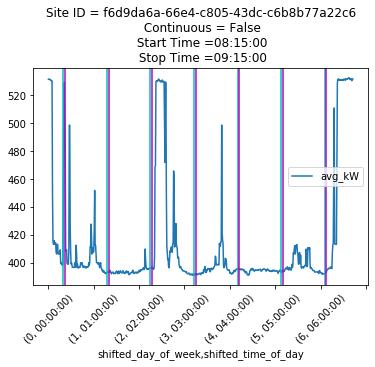

<Figure size 1080x288 with 0 Axes>

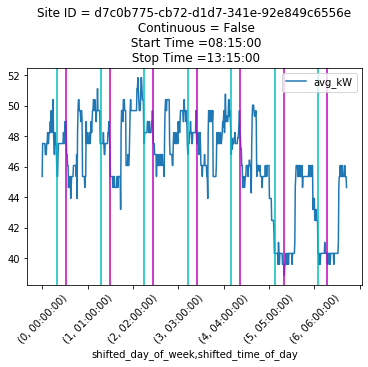

<Figure size 1080x288 with 0 Axes>

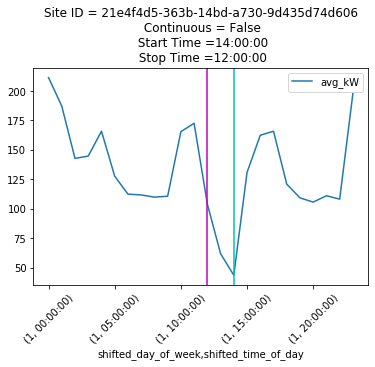

<Figure size 1080x288 with 0 Axes>

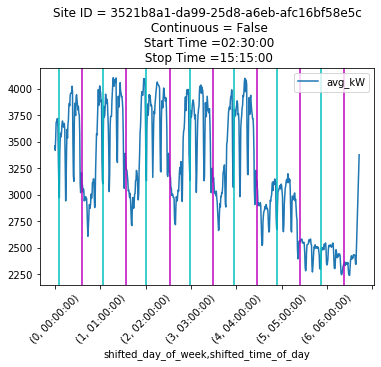

In [31]:
varying_inconclusive = ['f6d9da6a-66e4-c805-43dc-c6b8b77a22c6',
                        'd7c0b775-cb72-d1d7-341e-92e849c6556e',
                        '21e4f4d5-363b-14bd-a730-9d435d74d606',
                        '3521b8a1-da99-25d8-a6eb-afc16bf58e5c']
# plotting load profiles in blue, start time in cyan, and stop time in magenta.
functions_q12v.plot_site_operating_status(all_data_df, varying_inconclusive)

## Potential DR Event Dates
Site Id 'dbea811b-92f8-4e35-432c-9a7d19680a6d' had two potential DR events. The first appears to be on Thanksgiving and likely just represents an abnormal operating schedule while the second looks like it could potentially be a real DR event staring an hour or so before 21:00.

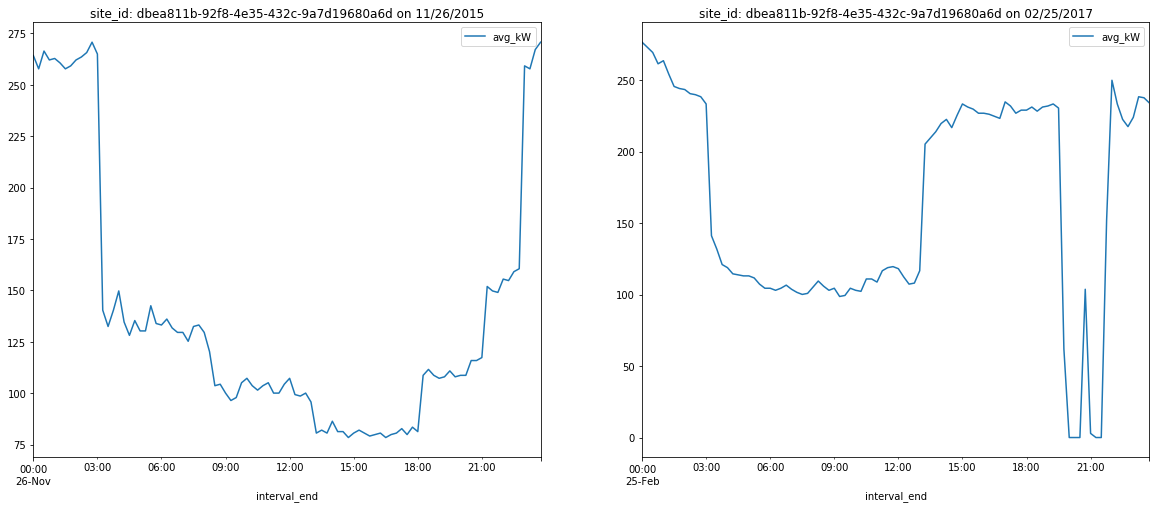

In [29]:
all_data_df['date'] = all_data_df['interval_end'].dt.date
plot_dr_dates = dr_event_data.loc[dr_event_data.index == 'dbea811b-92f8-4e35-432c-9a7d19680a6d',
                                  'potential_dr_dates']
plt.figure(figsize=(20,8))

for x, date in enumerate(plot_dr_dates):
    ax = plt.subplot(1, 2, x+1)
    all_data_df[['interval_end','avg_kW']].loc[(all_data_df['site_id'] == 'dbea811b-92f8-4e35-432c-9a7d19680a6d')
                              & (all_data_df['date'] == date)].plot(x='interval_end', y='avg_kW', ax=ax, legend=True)
    ax.set_title('site_id: '+'dbea811b-92f8-4e35-432c-9a7d19680a6d on '+date.strftime('%m/%d/%Y'))

In [32]:
plt.close('all')